# BCI-Motor imagery Data Preprocessing

- Import data and check stimulus events

In [1]:
import mne
import numpy as np
raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\class3_try_edf.edf",preload = True)
preprocess = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\class3_try2_edf.edf",preload = True)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\class3_try_edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107749  =      0.000 ...   430.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\class3_try2_edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107749  =      0.000 ...   430.996 secs...


Using matplotlib as 2D backend.


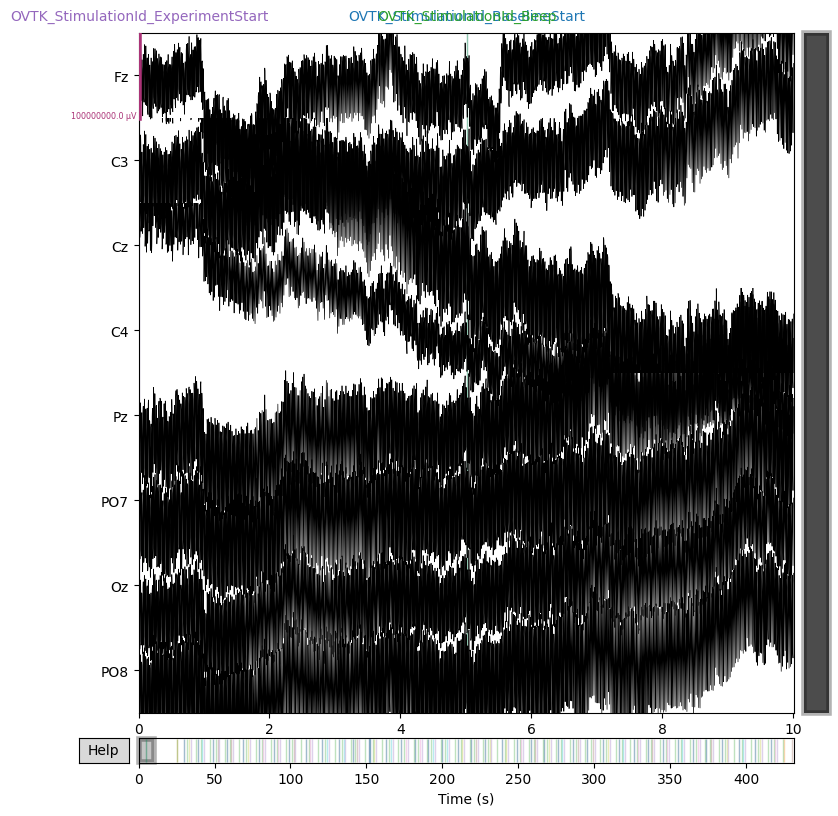

...


In [2]:
raw_edf.plot(
    duration=10, 
    start=0.0, 
    scalings=50, # You may edit scalings value later
    )
print("...")

- Digital Filter and Average Reference

In [4]:
filtered_eeg = raw_edf.copy().filter(l_freq=1.0, h_freq=30.0, method = 'iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


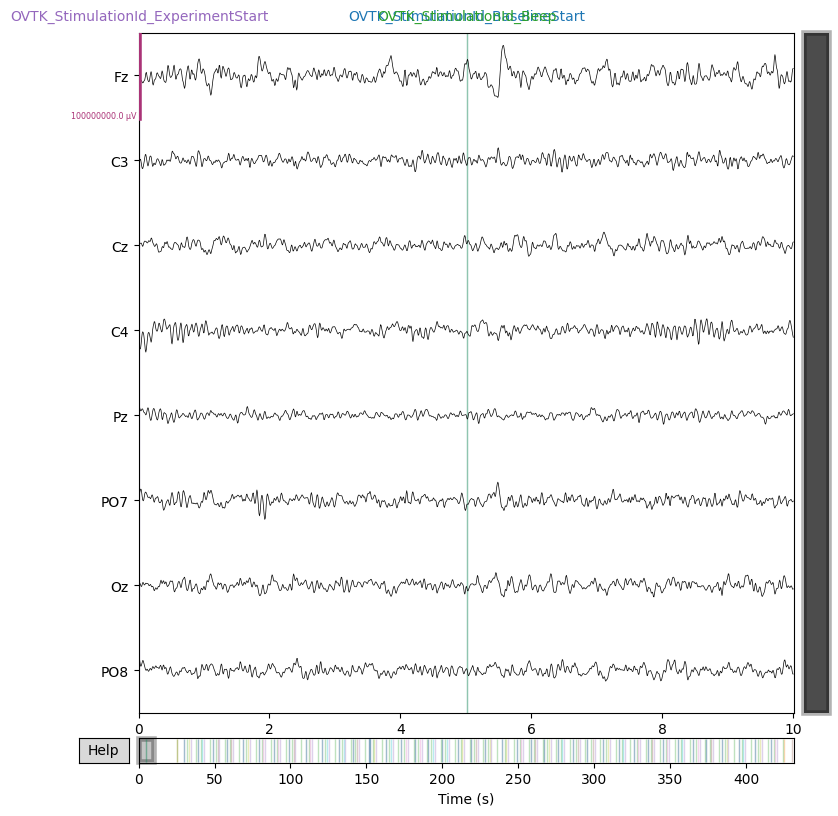

...


In [6]:
eeg_ref = filtered_eeg.copy().set_eeg_reference(ref_channels="average")
eeg_ref.plot(
    duration=10, 
    start=0.0, 
    scalings=50, # You may edit scalings value later
    )
print("...")

In [16]:
max(eeg_ref[2][0][0])

741.9085535019682

In [25]:
max(preprocess[0][0][0])

55.39694215396353

- Artifacts Removal

In [8]:
events, event_dict = mne.events_from_annotations(eeg_ref)
epochs = mne.Epochs(eeg_ref, events, 
        tmin=0.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=1.5,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
205 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 205 events and 376 original time points ...
1 bad epochs dropped


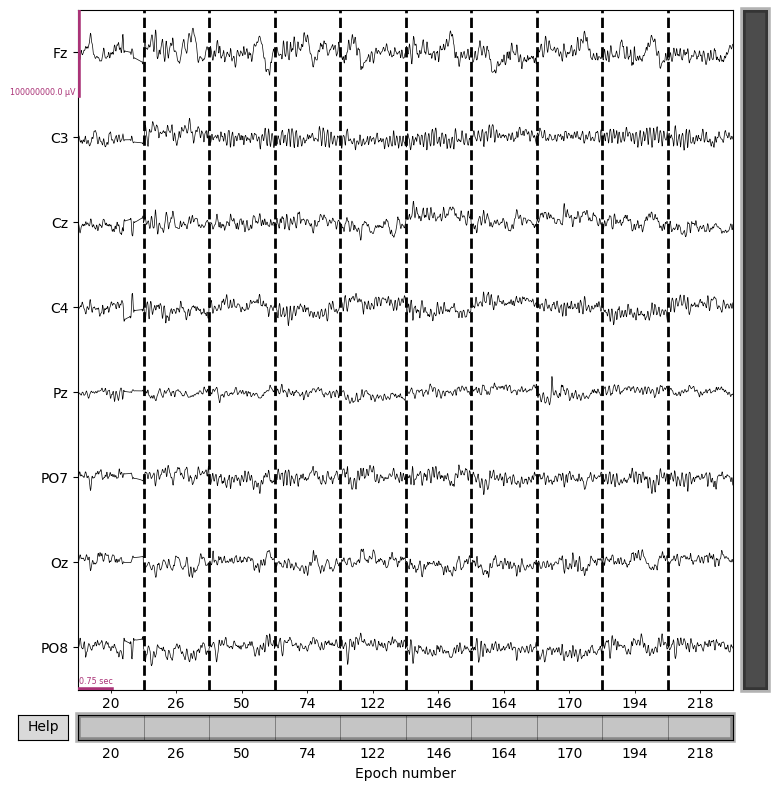

In [9]:
epochs['OVTK_GDF_Left'].plot(
    scalings=50, # You may edit scalings value later
    title='Left stimuli start',
)
left = epochs['OVTK_GDF_Tongue'].get_data()

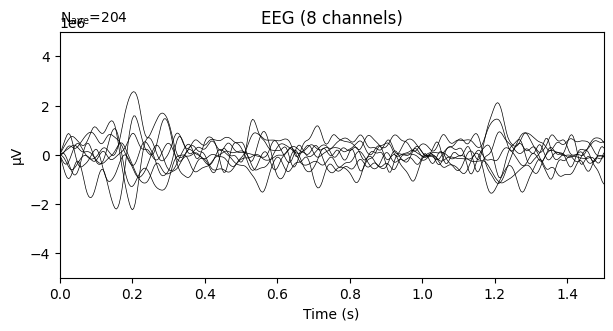

In [10]:
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-5000000, 5000000), eog=(-5, 15)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(600, 600)
